In [1]:
# import things
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from patchify import patchify, unpatchify
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras.backend as K

In [2]:
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives+K.epsilon())
        return recall
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives+K.epsilon())
        return precision
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [3]:
# Load the model you trained in task5_training.ipynb
from tensorflow.keras.models import load_model
patch_size = 256
example_file_name = f'michal_232079_unet_model_v3_{patch_size}px.h5'
model = load_model(example_file_name, custom_objects={"f1": f1})

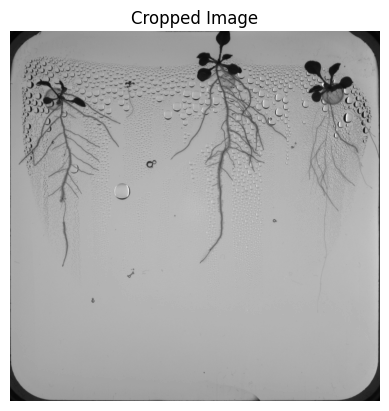

In [4]:
import cv2
import numpy as np

# Function to find edges by looping through a line
def find_edges(line, threshold=70):
    left_edge, right_edge = None, None
    n = len(line)
    
    # Loop from the left to find the first transition
    for i in range(1, n):
        if line[i-1] < threshold <= line[i] or line[i-1] >= threshold > line[i]:
            left_edge = i
            break
    
    # Loop from the right to find the last transition
    for i in range(n-1, 0, -1):
        if line[i] < threshold <= line[i-1] or line[i] >= threshold > line[i-1]:
            right_edge = i
            break
    
    return left_edge, right_edge

# Function to calculate crop slices based on detected edges
def format(image):
    # Horizontal and vertical slices for edge detection
    horizontal_line = image[image.shape[0] // 2, :]  # Middle row of the image
    vertical_line = image[:, image.shape[1] // 2]   # Middle column of the image
    
    # Find edges
    left_x, right_x = find_edges(horizontal_line)
    top_y, bottom_y = find_edges(vertical_line)
    
    # Ensure the output region is a square
    side_length = max(right_x - left_x, bottom_y - top_y)
    right_x = left_x + side_length
    bottom_y = top_y + side_length
    
    # Return slices for cropping
    return slice(top_y, bottom_y), slice(left_x, right_x)

# Load the image
image_path = 'task5_test_image.png'
original_image = cv2.imread(image_path, 0)  # Load as grayscale

# Crop the image and save the coordinates
crop_slices = format(original_image)
cropped_image = original_image[crop_slices]

# Save cropping coordinates for restoration
crop_coords = (crop_slices[0].start, crop_slices[0].stop, crop_slices[1].start, crop_slices[1].stop)

# Visualize the cropped image
import matplotlib.pyplot as plt
plt.imshow(cropped_image, cmap='gray')
plt.axis('off')
plt.title("Cropped Image")
plt.show()


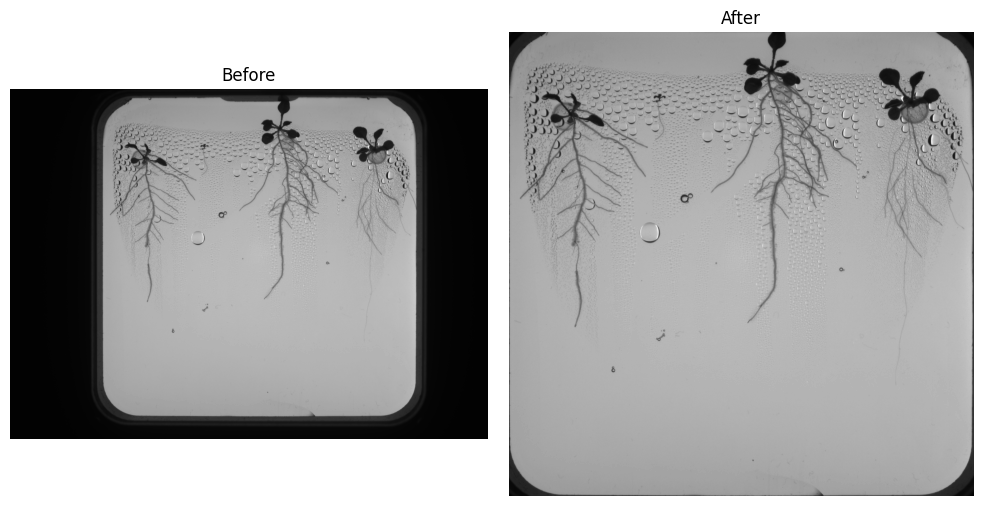

In [8]:
# Find the petri dish
image = original_image.copy()
petri_dish = image[format(image)]
petri_dish.shape


fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns
# Display the first image
axes[0].imshow(image, cmap = 'gray')
axes[0].axis('off')  # Turn off axes
axes[0].set_title("Before")

# Display the second image
axes[1].imshow(petri_dish, cmap = 'gray')
axes[1].axis('off')  # Turn off axes
axes[1].set_title("After")

# Adjust spacing and show the plot
plt.tight_layout()
plt.show()

In [9]:
def padder(image, patch_size):
    """
    Adds padding to an image to make its dimensions divisible by a specified patch size.

    Returns:
        padded_image (numpy.ndarray): The padded image.
        padding (tuple): The padding values as (top, bottom, left, right).
    """
    h = image.shape[0]
    w = image.shape[1]
    height_padding = ((h // patch_size) + 1) * patch_size - h
    width_padding = ((w // patch_size) + 1) * patch_size - w

    top_padding = int(height_padding / 2)
    bottom_padding = height_padding - top_padding

    left_padding = int(width_padding / 2)
    right_padding = width_padding - left_padding

    padded_image = cv2.copyMakeBorder(
        image,
        top_padding,
        bottom_padding,
        left_padding,
        right_padding,
        cv2.BORDER_CONSTANT,
        value=[0, 0, 0]
    )

    return padded_image, (top_padding, bottom_padding, left_padding, right_padding)

petri_dish_padded = padder(petri_dish, patch_size)

petri_dish_padded[0].shape

(2816, 2816)

4/4 [==============================] - 8s 459ms/step


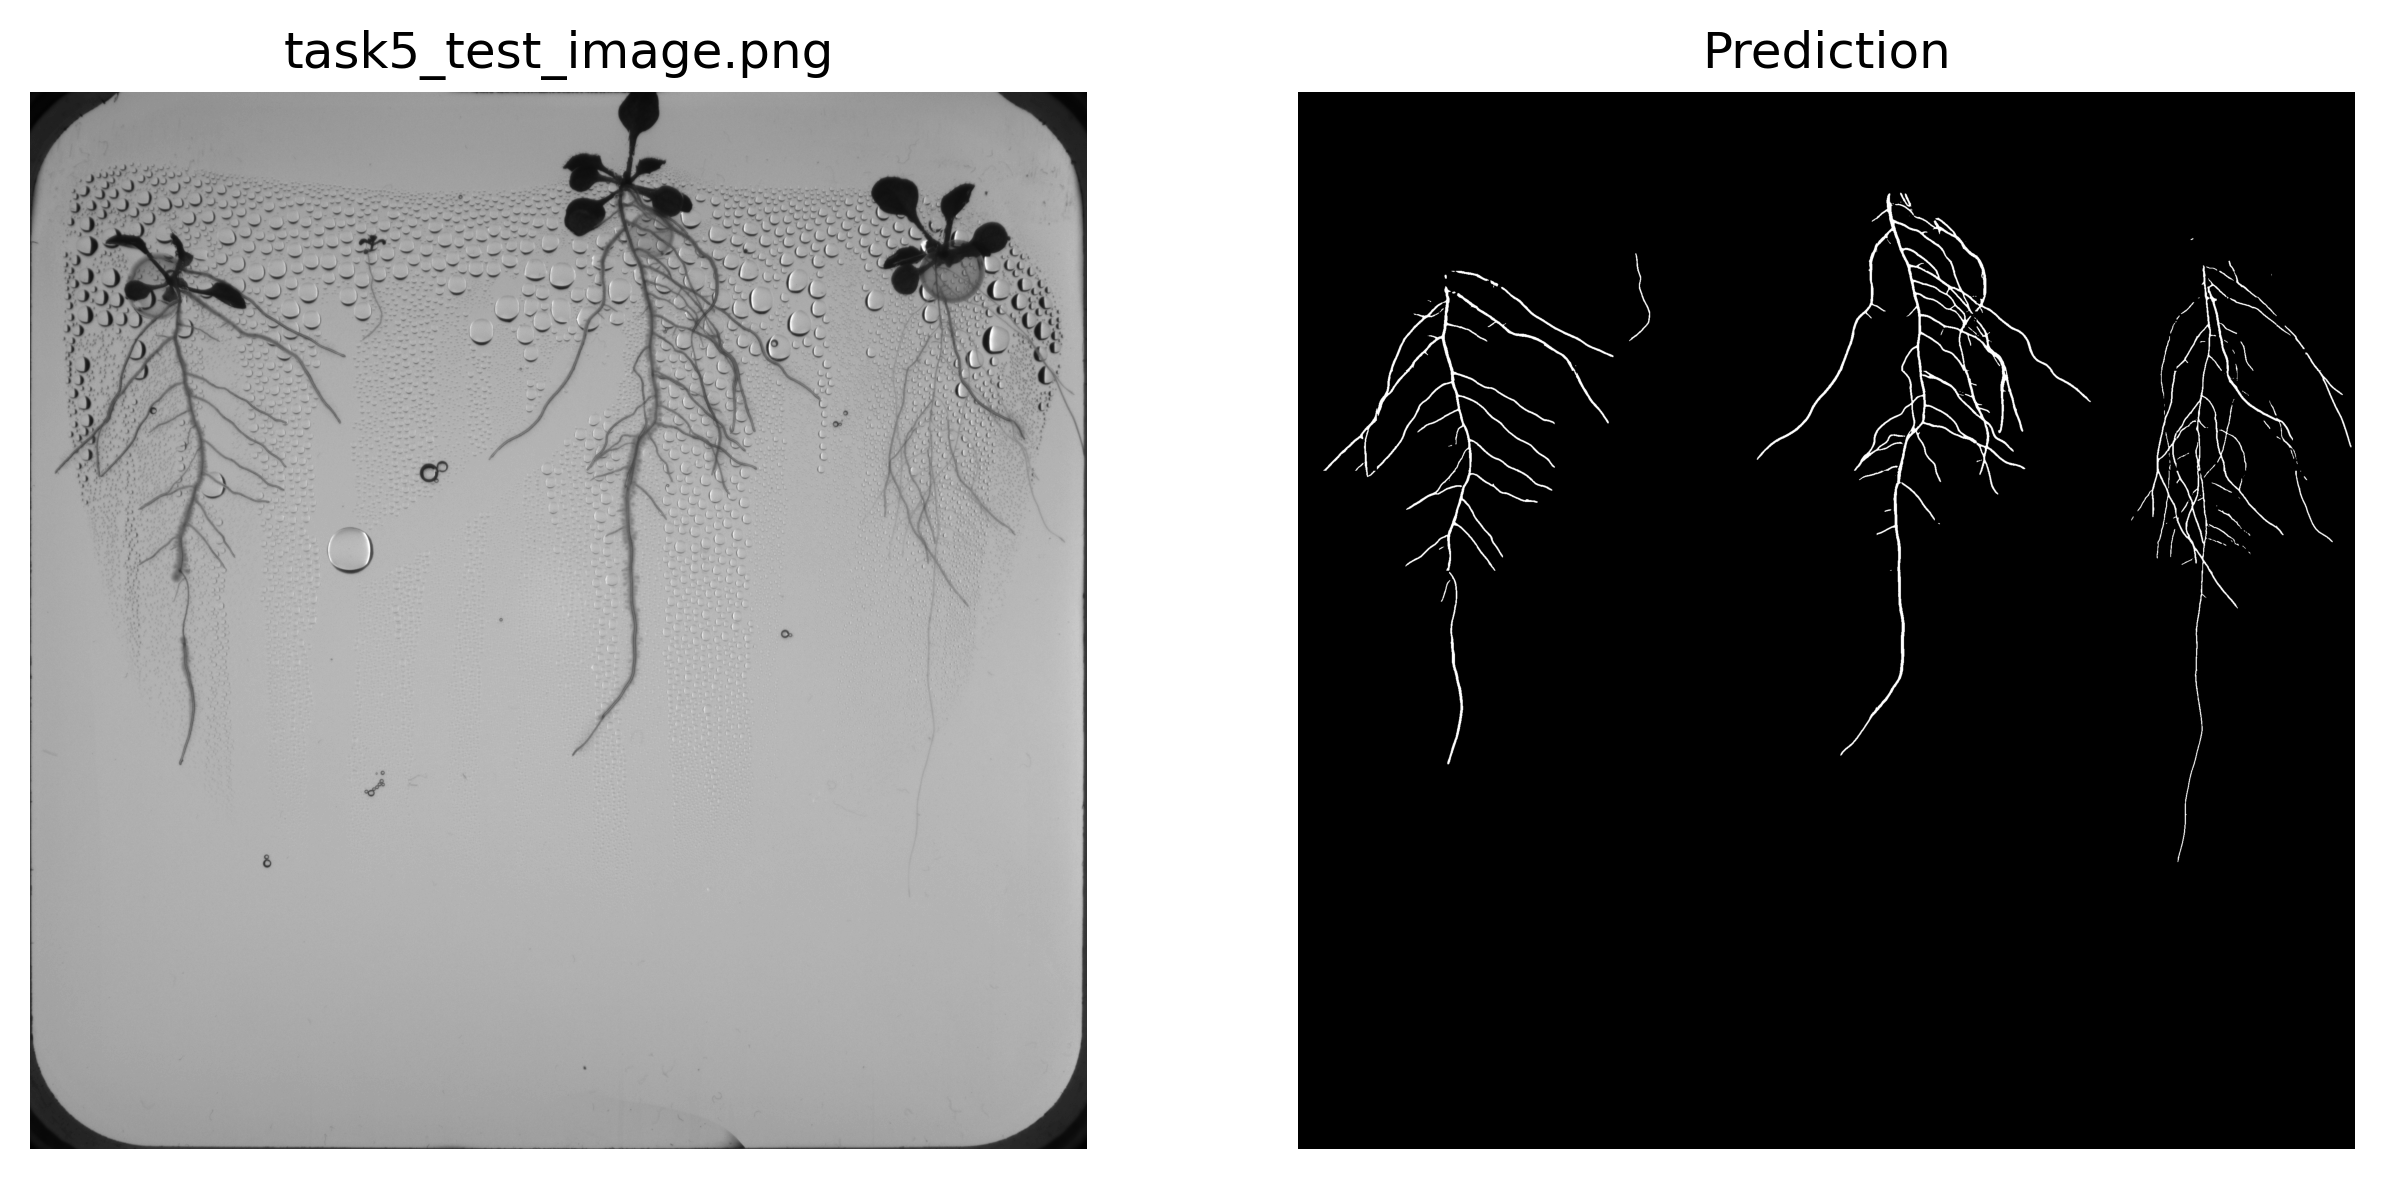

(2707, 2707)


In [10]:
# Pad the petri dish
from patchify import patchify, unpatchify

# Pad the cropped image
padded_image, padding = padder(cropped_image, patch_size)
top_padding, bottom_padding, left_padding, right_padding = padding

# Convert to 3 channels for patching
padded_image_3channel = np.repeat(padded_image[..., np.newaxis], 3, axis=-1)

# Create patches for prediction
patches = patchify(padded_image_3channel, (patch_size, patch_size, 3), step=patch_size)
patches_flat = patches.reshape(-1, patch_size, patch_size, 3) / 255.0  # Normalize

# Predict patches
predictions = model.predict(patches_flat)
predicted_patches = (predictions > 0.5).astype(np.uint8)
predicted_patches_reshaped = predicted_patches.reshape(
    patches.shape[0], patches.shape[1], patch_size, patch_size
)

# Unpatchify and remove padding
predicted_mask = unpatchify(predicted_patches_reshaped, padded_image.shape[:2])
predicted_mask_cropped = predicted_mask[
    top_padding:predicted_mask.shape[0] - bottom_padding,
    left_padding:predicted_mask.shape[1] - right_padding
]


# Visualize the results
f, ax = plt.subplots(1, 2, dpi=300, figsize=(10, 5))
ax[0].imshow(petri_dish, cmap='gray')
ax[0].axis('off')
ax[0].set_title('task5_test_image.png')
ax[1].imshow(predicted_mask_cropped, cmap='gray')
ax[1].axis('off')
ax[1].set_title('Prediction')
plt.show()
print(predicted_mask_cropped.shape)

As you can see `predicted_mask` and `image` have different shapes. This is because of cropping and padding.

**REQUIREMENT:** The input and output should have the same size and should be aligned perfectly. To achieve this, you need to reverse the effects of cropping and padding added during processing. This will ensure the final mask aligns with the original image.

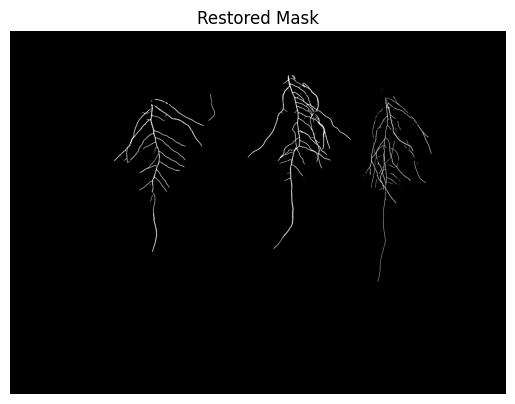

In [11]:
def reverse_crop(original_shape, cropped_image, crop_coords):
    """
    Restores the cropped image or mask to its original uncropped dimensions.
    """
    restored_image = np.zeros(original_shape, dtype=cropped_image.dtype)
    top, bottom, left, right = crop_coords
    restored_image[top:bottom, left:right] = cropped_image
    return restored_image

# Restore the mask to original dimensions
restored_mask = reverse_crop(original_image.shape, predicted_mask_cropped, crop_coords)

# Visualize the restored mask
plt.imshow(restored_mask, cmap='gray')
plt.axis('off')
plt.title("Restored Mask")
plt.show()


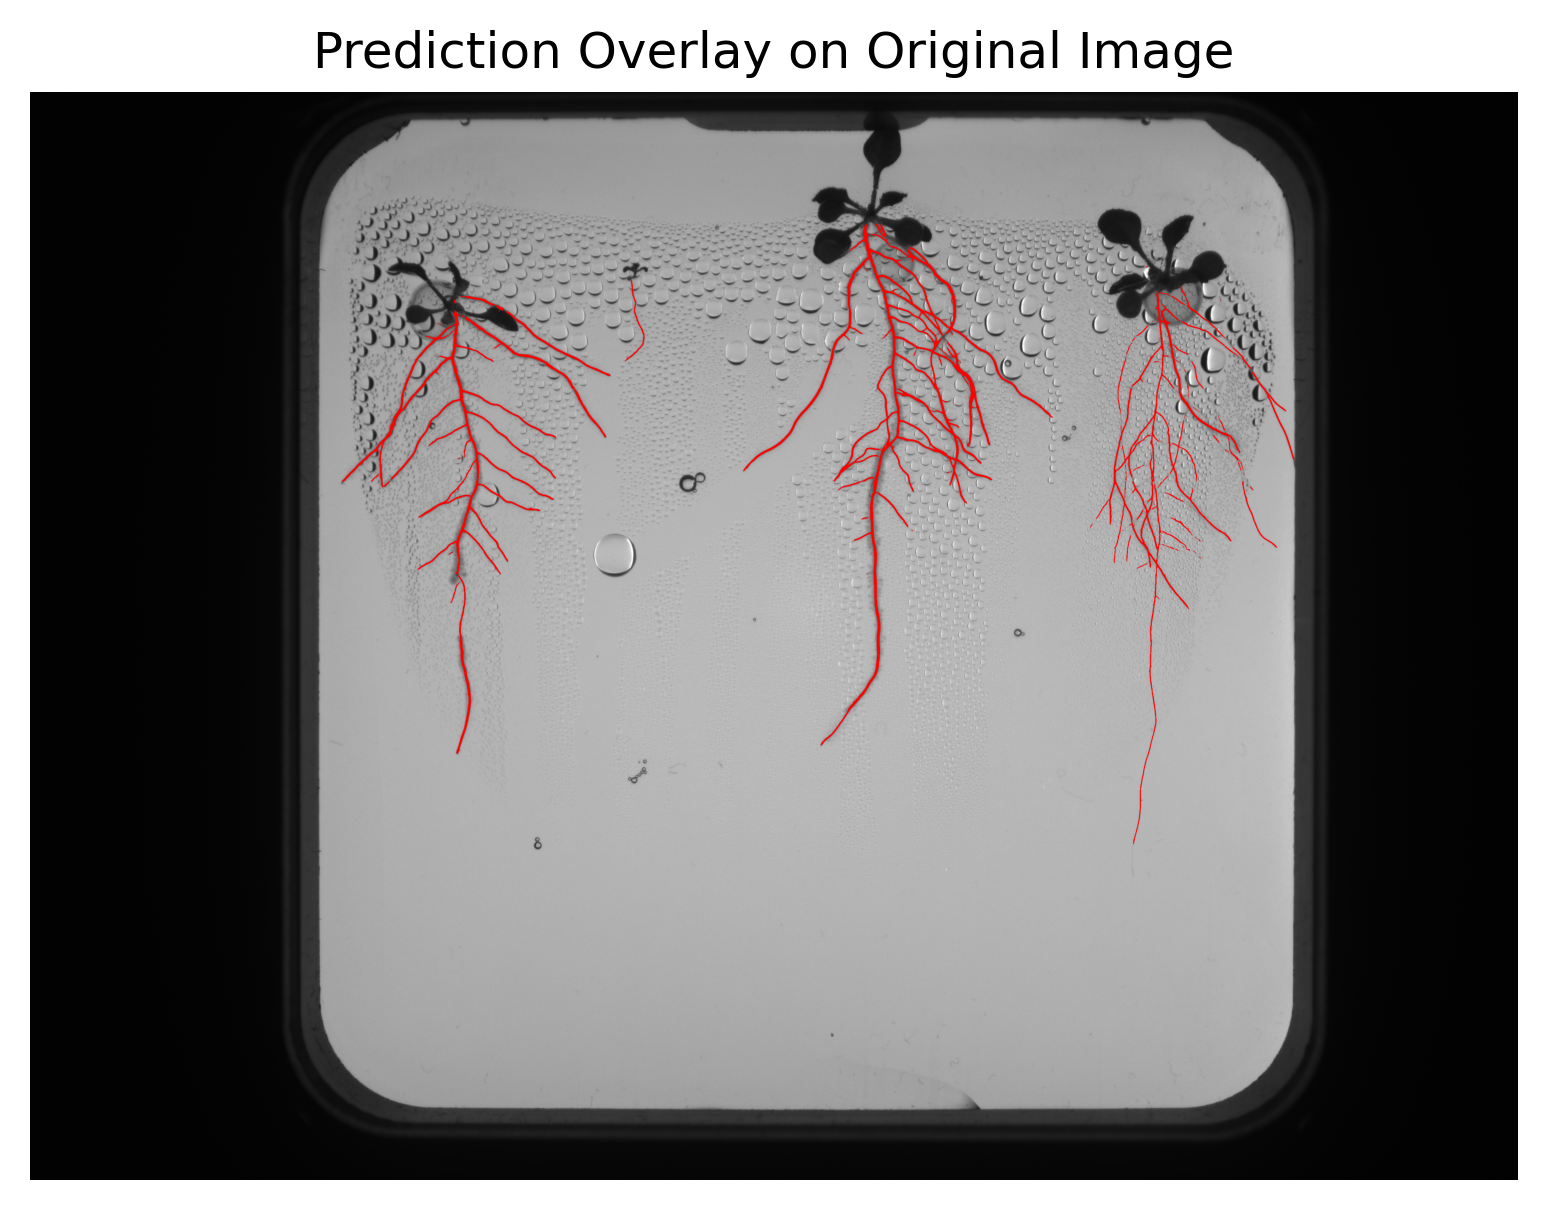

In [12]:
def overlay_restored_image(original_image, restored_mask):
    """
    Creates an overlay of the predicted mask on the original uncropped image.
    """
    # Ensure the restored mask matches the original image dimensions
    assert restored_mask.shape[:2] == original_image.shape[:2], \
        "Shapes of mask and image do not match!"

    # Convert original image to RGB if it's grayscale
    if len(original_image.shape) == 2:  # Grayscale
        original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_GRAY2RGB)
    else:
        original_image_rgb = original_image.copy()

    # Create the overlay
    overlay_image = original_image_rgb.copy()
    overlay_image[restored_mask > 0] = [255, 0, 0]  # Red overlay for mask (root pixels)

    # Plot the overlay
    plt.figure(dpi=300)
    plt.imshow(overlay_image)
    plt.axis('off')
    plt.title("Prediction Overlay on Original Image")
    plt.show()

# Overlay and visualize
overlay_restored_image(original_image, restored_mask)


In [13]:
restored_mask.shape

(3006, 4112)

In [14]:
# REQUIREMENT: Save the predicted mask, it is a deliverable.
# REQUIREMENT: Input/Output size must be the same.
# REQUIREMENT: Predicted roots must align with the original image.
# REQUIREMENT: The predicted mask must be binary.
# REQUIREMENT: Non-root pixels must be 0, root pixels must be 255 (unlike Task 1)
# REQUIREMENT: naming convention task5_test_image_prediction_studentname_studentnumber.png


In [15]:
cv2.imwrite("task5_test_image_prediction_michal_232079_v3.png", (restored_mask * 255).astype(np.uint8))


True